卷积神经网络的出现彻底改变了计算机视觉，基于图像的系统从此获得了一系列新的能力

图像表示为按规则网格排列的标量集合，并且具有高度和宽度（以像素为单位）。每个网格点（像素）可能只有一个标量，这种图像表示为灰度图像；或者每个网格点可能有多个标量，它们通常代表不同的颜色或不同的特征（features），例如从深度相机获得的深度。

代表单个像素值的标量通常使用8位整数编码，例如在消费类相机中。在医学、科学和工业应用中，你经常会发现具有较高数字精度的像素，例如12位和16位。如果像素对有关物理特性的信息例如骨密度、温度或深度进行编码，则此高精度可提供更大的（表示）范围或更高的灵敏度。

你有几种用数字编码颜色的方法。最常见的是RGB，它定义用三个数字表示颜色，这三个数字分别代表红色、绿色和蓝色的强度。

---

#### 0 引入模块

In [124]:
import imageio
import torch
import numpy as np
import pandas as pd

#### 1 加载图像

首先使用imageio模块加载PNG图像。因为它通过统一的API处理不同的数据类型。

In [125]:
img_path = r"./data/chapter3/bobby.jpg"
img_arr = imageio.imread(image_path)
img_arr.shape  # (720, 1280, 3)  3是RGB通道。

(720, 1280, 3)

img_arr是一个NumPy数组对象，它有三个维度：两个空间维度（宽度和高度），以及对应于红色、绿色和蓝色的第三个维度。

目前的输入张量 W x H x C

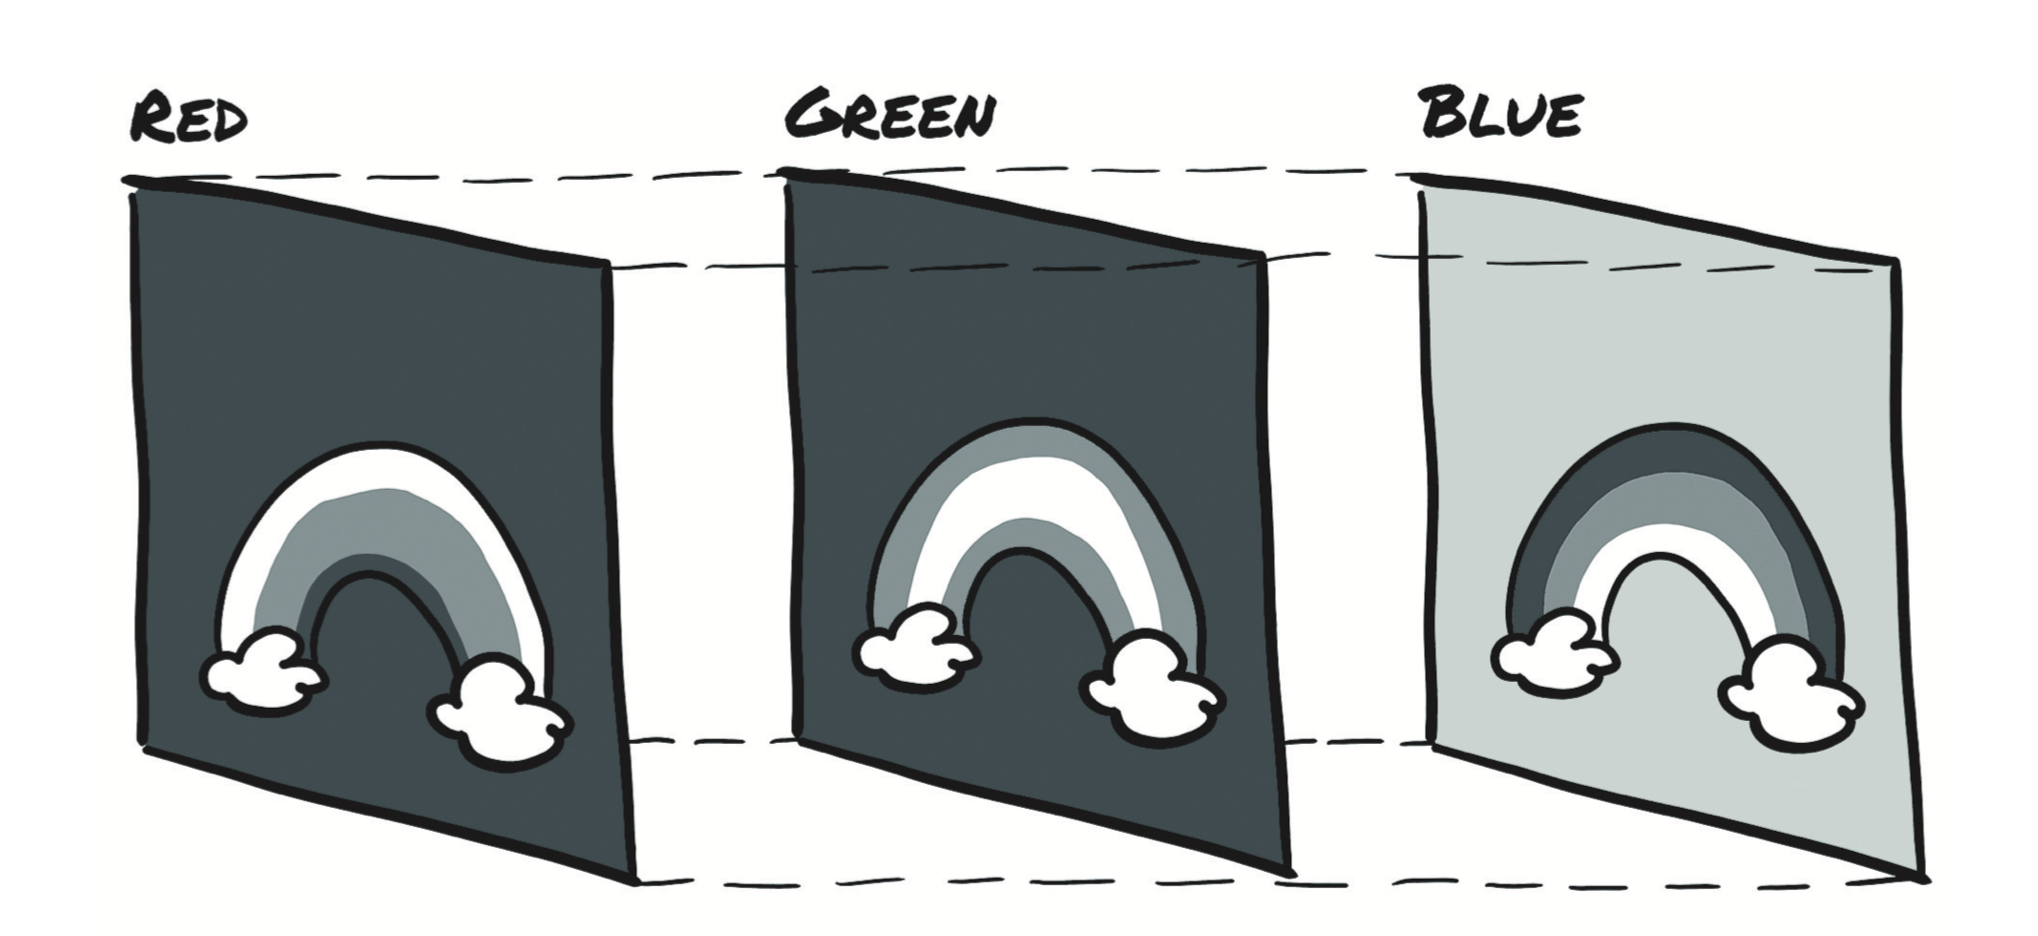

#### 2 PyTorch模块处理图像数据需要将输入张量设置为C x H x W（分别为通道、高度和宽度）。
说明： png为RGBA四通道  JPG为RGB三通道

In [126]:
# W H C 转置为 C H W 
    # 注意这里只是view层面的改变
img = torch.tensor(img_arr)
out = torch.transpose(img,dim0=0,dim1=2)
out.shape  

torch.Size([3, 1280, 720])

#### 3 遵循与以前的数据类型相同的策略，创建包含多个图像的数据集以用作神经网络的输入，然后沿着第一维将这些图像按照批量存储，以获得N x C x H x W 张量。


一个高效的选择就是使用堆叠（stack）来构建这个张量，你可以预先分配适当尺寸的张量，并用从文件夹中加载图像填充它，

In [127]:
    # 用零张量构建一个堆叠
        # 这表示你的批次将包含100个RGB图像，分别为256像素高度和256像素宽度。
batch_size = 100
    # 说明： png为RGBA四通道C=4  JPG为RGB三通道C=3
n_cannels = 4
batch = torch.zeros(batch_size,n_cannels,256,256,dtype=torch.uint8)  # N C H W

#### 3.1 现在你可以从输入的文件夹中加载所有的png图像并将其填充在张量中

In [128]:
import os

In [129]:
data_dir = r"./data/chapter3/image-cats/"

In [130]:
# 测试
    # os.listdir()  # os.path.splitext() 
os.listdir(data_dir),os.path.splitext('cat1.png'),os.path.splitext('cat1.png')[-1]

(['cat1.png', 'cat2.png', 'cat3.png'], ('cat1', '.png'), '.png')

In [145]:
# *.png文件名列表
filenames = [name  for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
# 限制读取文件的数目不大于batch_size
filenames = filenames[:batch_size]
    # 从输入的文件夹中加载所有的png图像 来 填充堆叠（stack） 
for i,filename in enumerate(filenames):
    img_arr = imageio.imread(data_dir+filename)
    batch[i] = torch.transpose(torch.from_numpy(img_arr), 0, 2)

# 查看尺寸    
batch.shape,batch[0].shape

(torch.Size([100, 4, 256, 256]), torch.Size([4, 256, 256]))

#### 4 将张量转换为浮点数并归一化像素值

计算输入数据的均值和标准偏差并对其进行缩放，以便于在**每个通道**上的均值和单位标准偏差输出为零

In [146]:
batch = batch.float() # float
n_cannels = batch.shape[1] # NxCxWxH
for c in range(n_cannels):
    mean = torch.mean(batch[:,c])
    std = torch.std(batch[:,c])
    batch[:,c] = (batch[:,c]- mean)/std